In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.spatial import cKDTree

In [7]:
csv = '../AnalysisReadyDataFrames/bronx_df.csv'
df = pd.DataFrame(pd.read_csv(csv))

In [8]:
df.head()

,Borough,Area,Address,Num_Beds,Num_Baths,Sq-Ft,Rent,Long,Lat,ZipCode,Precinct,CrimeTotalPastYear
0,bronx,Tremont,2065 Ryer Avenue,2.0,1.0,719.00,2217.0,-73.901209,40.852362,10457.0,46.0,2002.0
1,bronx,Crotona Park East,1169 Hoe Avenue,2.0,1.0,848.76,2425.0,-73.890999,40.827804,10459.0,42.0,1957.0
2,bronx,Highbridge,1515 Macombs Road,1.0,1.0,631.43,1800.0,-73.917725,40.843560,10452.0,44.0,2726.0
3,bronx,Norwood,31 West Mosholu Parkway North,2.0,1.0,833.22,1950.0,-73.884467,40.881828,10467.0,52.0,2092.0
4,bronx,west concourse,2401 3rd Avenue,1.0,1.0,675.00,3132.0,-73.931714,40.808009,10451.0,44.0,2726.0


### Get nearest train line

In [10]:
lines_json = "../SimplifiedGeoJson/reduced_lines.json"

In [12]:
with open(lines_json, 'r') as fp:
    lines_data = json.load(fp)

In [13]:
agg_lines = {}

In [14]:
for f in lines_data['features']:
    if f['line_name'] not in agg_lines:
        agg_lines[f['line_name']] = []
    
    agg_lines[f['line_name']] += f['coords']

In [15]:
# write lines aggregate to file for later use
with open('sublines_agg.json', 'w') as fp:
    json.dump(agg_lines, fp)

In [9]:
train_lines_ckd = {}

In [16]:
def create_lines_ckd(ckd_map:dict, lines_data:dict):
    for line in lines_data.keys():
        if line not in ckd_map:
            ckd_map[line] = None
        
        ckd_map[line] = cKDTree(lines_data[line])


In [17]:
create_lines_ckd(train_lines_ckd, agg_lines)

In [18]:
train_lines_ckd.keys()

dict_keys(['G', 'Q', 'M', 'S', 'A', 'B-D', 'B-D-F-M', 'R', 'N-Q-R', 'N-Q', 'N-R', 'F', 'F-M', 'E', '7', 'J-Z', 'L', 'A-C', 'D', '1-2-3', 'B', '4-5-6', 'N', '1', 'N-W', '2-3', '2', '4-5', '5', '4', '3', 'A-C-E', 'N-Q-R-W', 'N-R-W', '6', 'R-W'])

In [20]:
def grid_search_line(lon, lat):
    nearests = []
    for line in train_lines_ckd:
        dist, _ = train_lines_ckd[line].query([lon, lat], k=1)
        nearests.append([dist, line])
    
    nearests.sort(key= lambda x: x[0])

    return nearests[0][1]

In [21]:
df['Train_Line'] = None

In [22]:
for idx, row in df.iterrows():
    lon, lat = row['Long'], row['Lat'],
    line_nearest = grid_search_line(lon, lat)
    df.at[idx, 'Train_Line'] = line_nearest

In [23]:
df

,Borough,Area,Address,Num_Beds,Num_Baths,Sq-Ft,Rent,Long,Lat,ZipCode,Precinct,CrimeTotalPastYear,Train_Line
0,bronx,Tremont,2065 Ryer Avenue,2.0,1.0,719.00,2217.0,-73.901209,40.852362,10457.0,46.0,2002.0,B-D
1,bronx,Crotona Park East,1169 Hoe Avenue,2.0,1.0,848.76,2425.0,-73.890999,40.827804,10459.0,42.0,1957.0,5
2,bronx,Highbridge,1515 Macombs Road,1.0,1.0,631.43,1800.0,-73.917725,40.843560,10452.0,44.0,2726.0,4
3,bronx,Norwood,31 West Mosholu Parkway North,2.0,1.0,833.22,1950.0,-73.884467,40.881828,10467.0,52.0,2092.0,4
4,bronx,west concourse,2401 3rd Avenue,1.0,1.0,675.00,3132.0,-73.931714,40.808009,10451.0,44.0,2726.0,4-5-6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,bronx,Riverdale,3210 Riverdale Avenue,1.0,1.0,794.00,2300.0,-73.908409,40.882555,10463.0,50.0,1027.0,1
682,bronx,Spuyten Duyvil,638 West 227th Street,2.0,1.5,1100.00,2500.0,-73.916652,40.880920,10463.0,50.0,1027.0,1
683,bronx,Highbridge,1395 Nelson Avenue,0.5,1.0,527.26,1625.0,-73.922448,40.841984,10452.0,44.0,2726.0,4
684,bronx,North New York,510 Jackson Avenue,3.0,1.0,1036.65,2150.0,-73.909304,40.812281,10455.0,42.0,1957.0,6


In [24]:
df.to_csv(csv, index=False)

In [25]:
df.columns

Index(['Borough', 'Area', 'Address', 'Num_Beds', 'Num_Baths', 'Sq-Ft', 'Rent',
       'Long', 'Lat', 'ZipCode', 'Precinct', 'CrimeTotalPastYear',
       'Train_Line'],
      dtype='object')

In [26]:
# Bed, Bath, Sq-Ft, Rent, Correlation

df1 = df[['Num_Beds', 'Num_Baths', 'Sq-Ft', 'Rent']]

<AxesSubplot:>

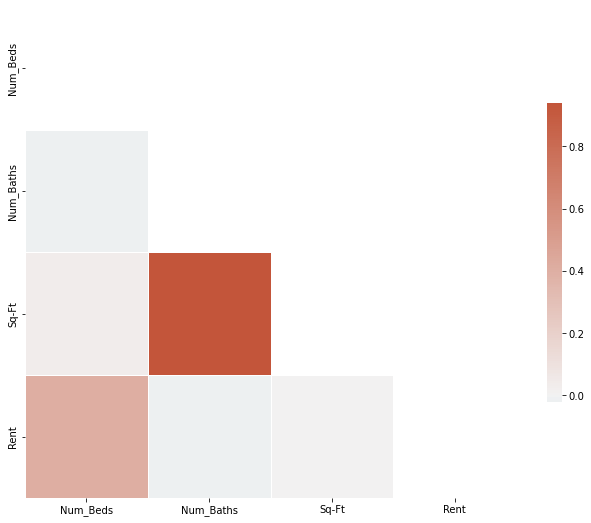

In [27]:
corr_mat1 = df1.corr(method='pearson')
mask = np.triu(np.ones_like(corr_mat1, dtype=bool))

f, ax = plt.subplots(figsize=(11, 11))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr_mat1, mask=mask, cmap=cmap, robust=True, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

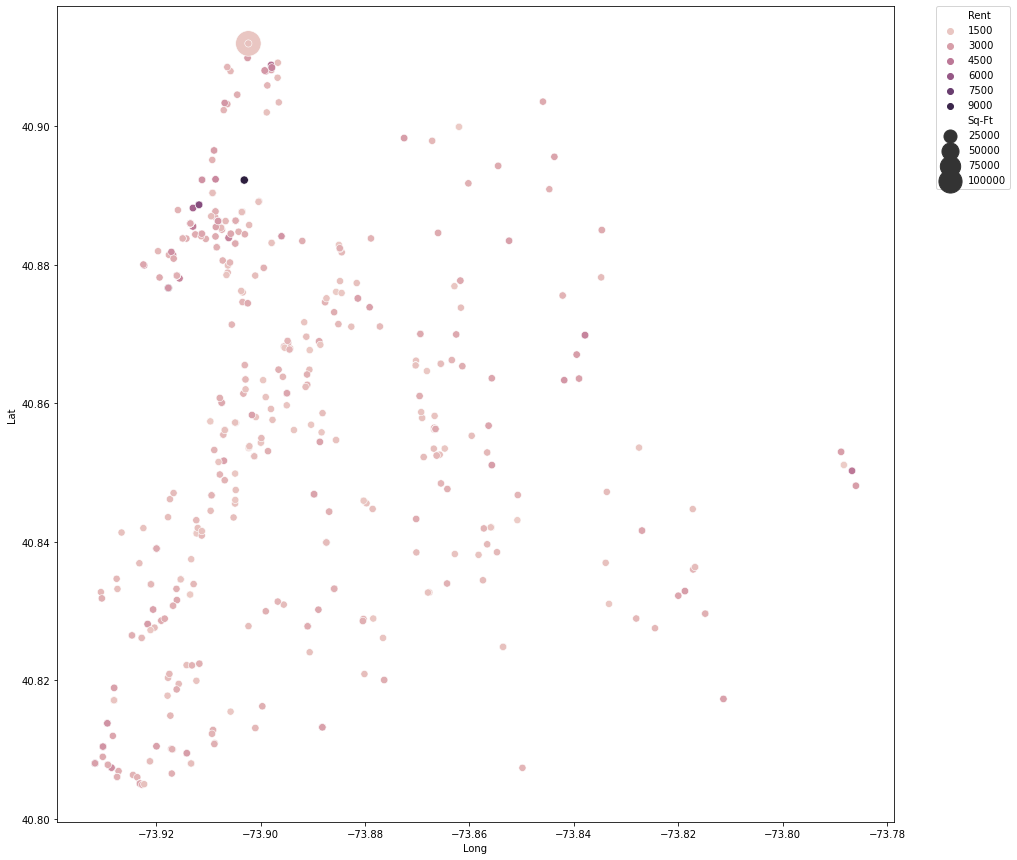

In [28]:
plt.figure(figsize=(15,15))
sns.scatterplot(data=df, x='Long', y='Lat', hue='Rent', size='Sq-Ft', sizes=(50, 650))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

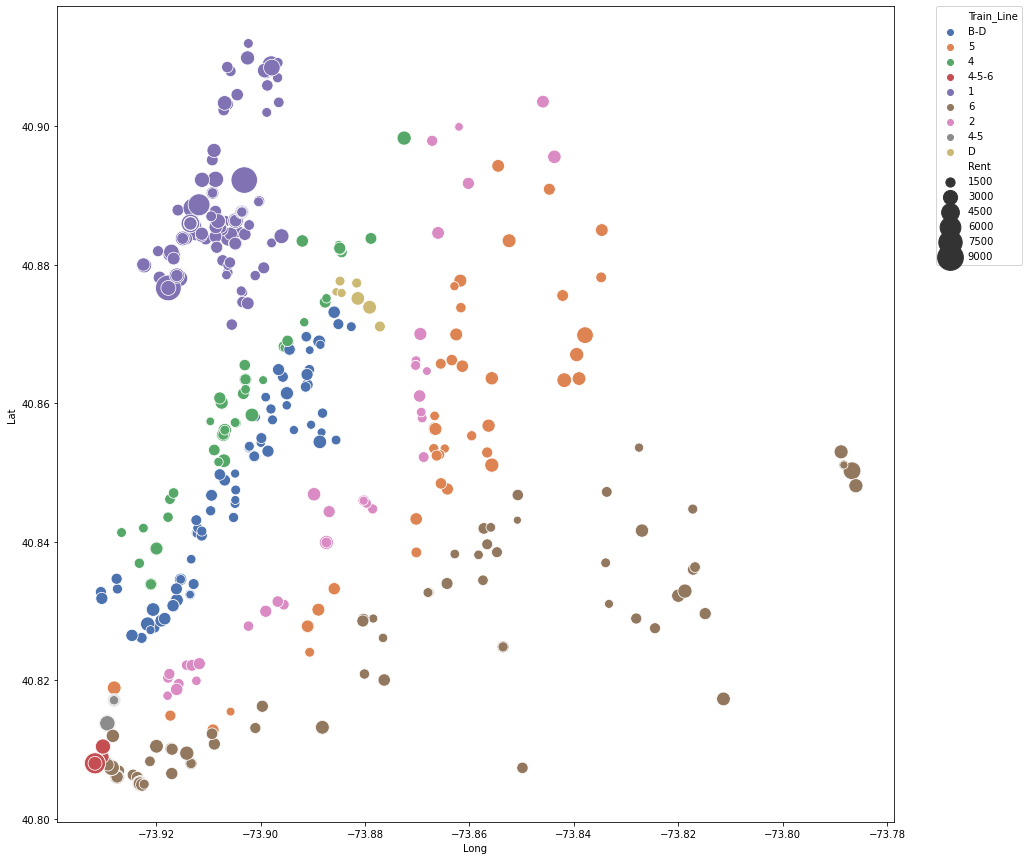

In [29]:
plt.figure(figsize=(15,15))
sns.scatterplot(data=df, x='Long', y='Lat', hue='Train_Line', size='Rent', sizes=(50, 700), palette=sns.color_palette('deep', df['Train_Line'].unique().shape[0]))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


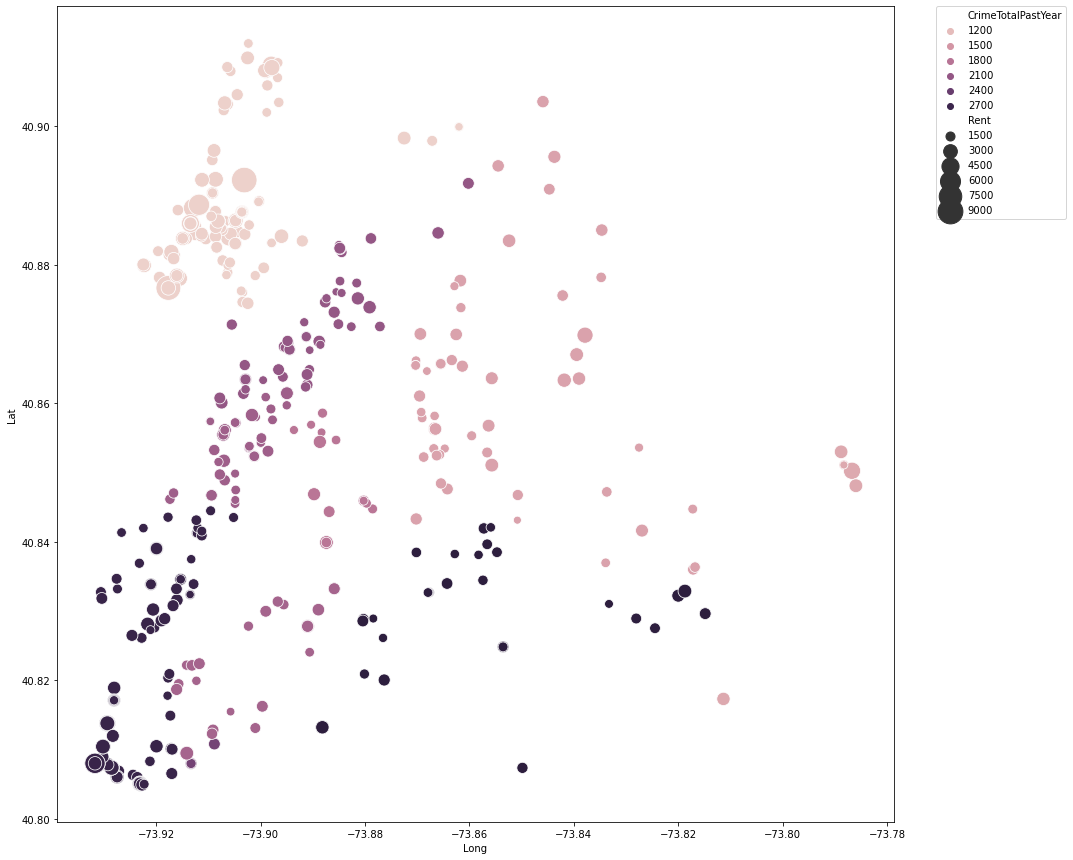

In [30]:
plt.figure(figsize=(15,15))
sns.scatterplot(data=df, x='Long', y='Lat', hue='CrimeTotalPastYear', size='Rent', sizes=(50, 650))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


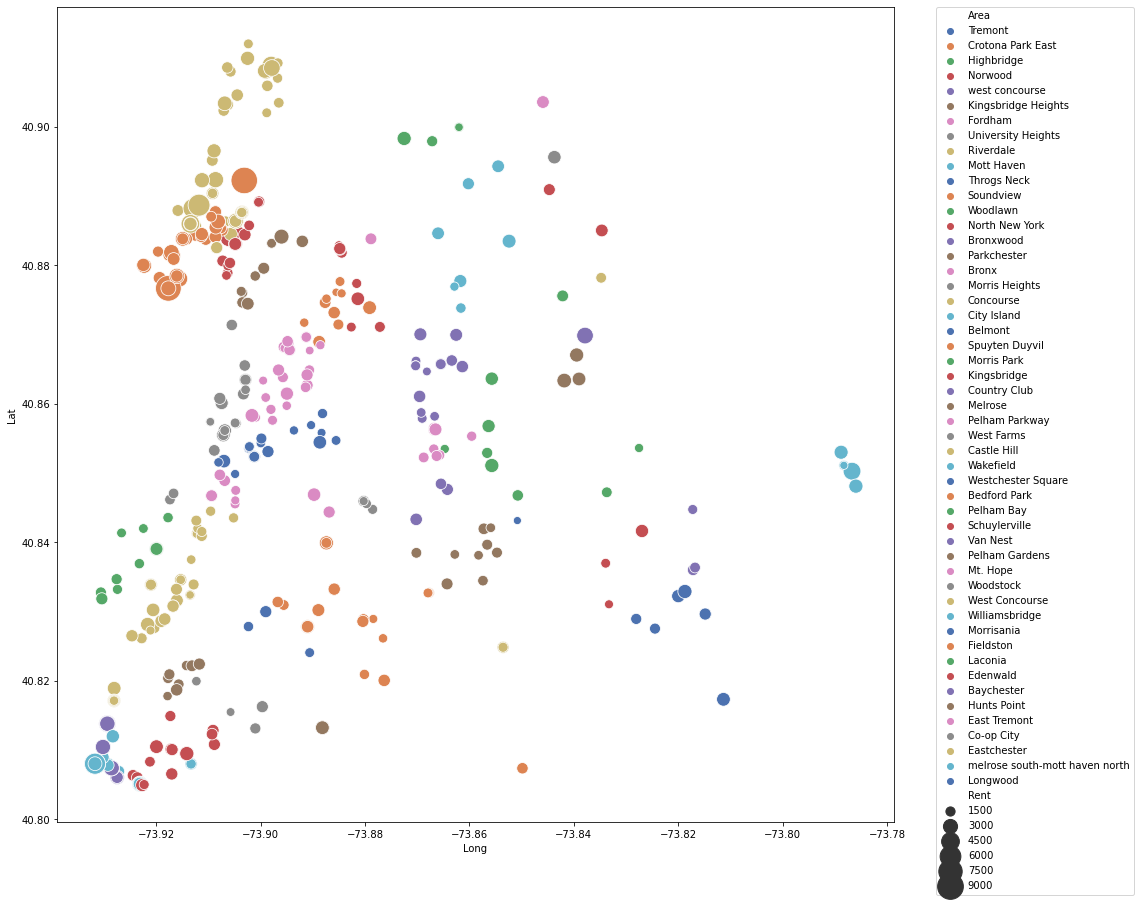

In [31]:
plt.figure(figsize=(15,15))
sns.scatterplot(data=df, x='Long', y='Lat', hue='Area', size='Rent', sizes=(50, 700), palette=sns.color_palette('deep', df['Area'].unique().shape[0]))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [32]:
# correlation between crime and rent

df3 = df[['Sq-Ft', 'Num_Beds', 'Num_Baths', 'CrimeTotalPastYear', 'Rent']]

<AxesSubplot:>

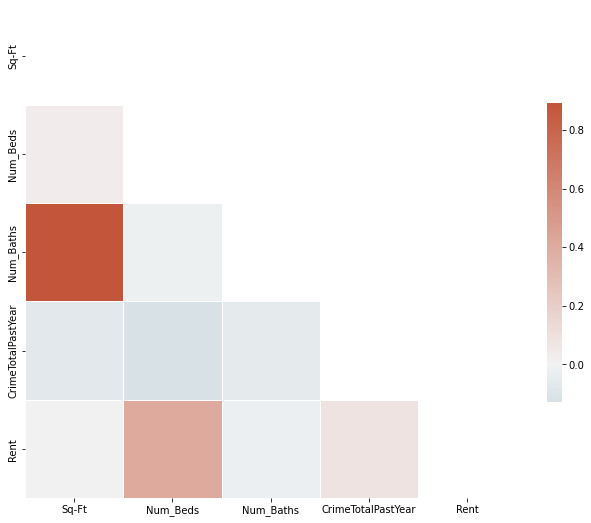

In [33]:
corr_mat3 = df3.corr(method='pearson')
mask = np.triu(np.ones_like(corr_mat3, dtype=bool))

f, ax = plt.subplots(figsize=(11, 11))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr_mat3, mask=mask, cmap=cmap, robust=True, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

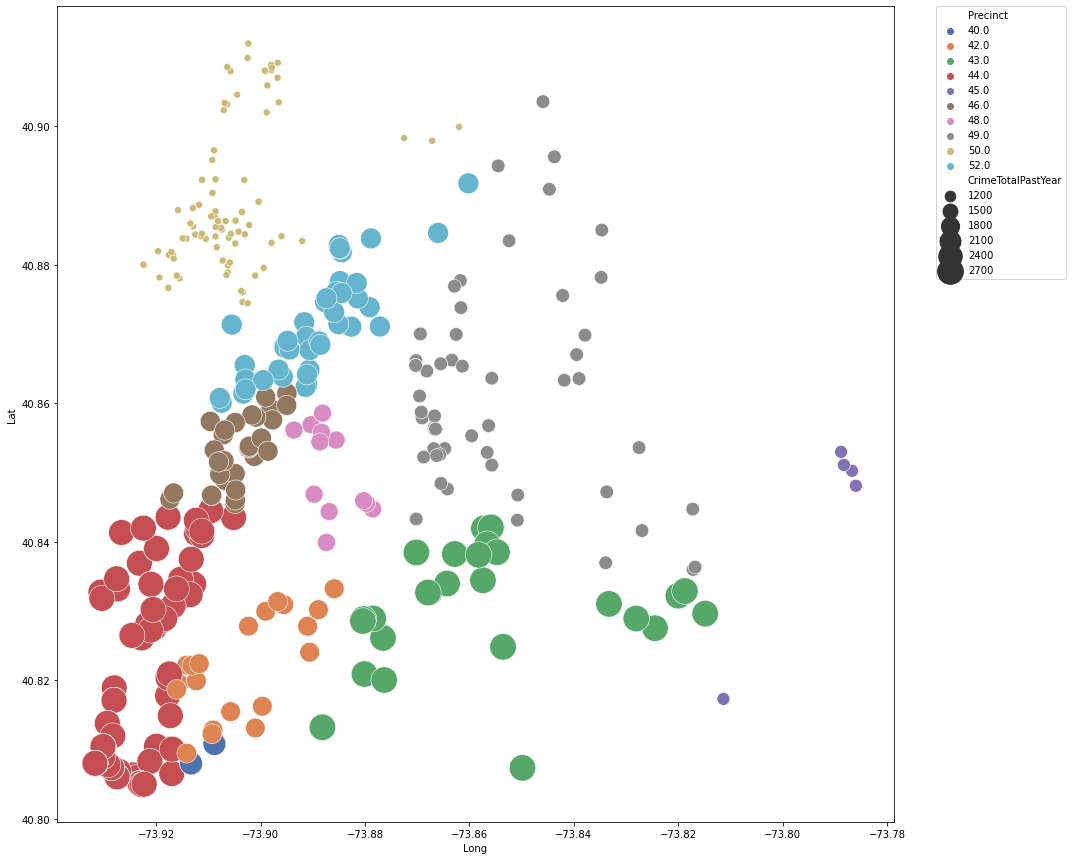

In [34]:
plt.figure(figsize=(15,15))
sns.scatterplot(data=df, x='Long', y='Lat', hue='Precinct', size='CrimeTotalPastYear', sizes=(50, 700), palette=sns.color_palette('deep', df['Precinct'].unique().shape[0]))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


### Add distance to nearest line column

In [35]:
cbdf = pd.DataFrame(pd.read_csv(csv))
cbdf['Dist_To_Line'] = None

for idx, row in cbdf.iterrows():
    lon, lat, line_name = row['Long'], row['Lat'], row['Train_Line']
    dist,_ = train_lines_ckd[line_name].query([lon, lat], k=1)
    cbdf.at[idx, 'Dist_To_Line'] = dist


In [36]:
cbdf

,Borough,Area,Address,Num_Beds,Num_Baths,Sq-Ft,Rent,Long,Lat,ZipCode,Precinct,CrimeTotalPastYear,Train_Line,Dist_To_Line
0,bronx,Tremont,2065 Ryer Avenue,2.0,1.0,719.00,2217.0,-73.901209,40.852362,10457.0,46.0,2002.0,B-D,0.002654
1,bronx,Crotona Park East,1169 Hoe Avenue,2.0,1.0,848.76,2425.0,-73.890999,40.827804,10459.0,42.0,1957.0,5,0.002137
2,bronx,Highbridge,1515 Macombs Road,1.0,1.0,631.43,1800.0,-73.917725,40.843560,10452.0,44.0,2726.0,4,0.003163
3,bronx,Norwood,31 West Mosholu Parkway North,2.0,1.0,833.22,1950.0,-73.884467,40.881828,10467.0,52.0,2092.0,4,0.002087
4,bronx,west concourse,2401 3rd Avenue,1.0,1.0,675.00,3132.0,-73.931714,40.808009,10451.0,44.0,2726.0,4-5-6,0.00268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,bronx,Riverdale,3210 Riverdale Avenue,1.0,1.0,794.00,2300.0,-73.908409,40.882555,10463.0,50.0,1027.0,1,0.005144
682,bronx,Spuyten Duyvil,638 West 227th Street,2.0,1.5,1100.00,2500.0,-73.916652,40.880920,10463.0,50.0,1027.0,1,0.009226
683,bronx,Highbridge,1395 Nelson Avenue,0.5,1.0,527.26,1625.0,-73.922448,40.841984,10452.0,44.0,2726.0,4,0.004929
684,bronx,North New York,510 Jackson Avenue,3.0,1.0,1036.65,2150.0,-73.909304,40.812281,10455.0,42.0,1957.0,6,0.003085
